<h2 align=center>Generative Adversarial Networks: Video Generator with DCGAN</h2>

## Importing Libraries

In [2]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.0


## Loading and Preprocessing the Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

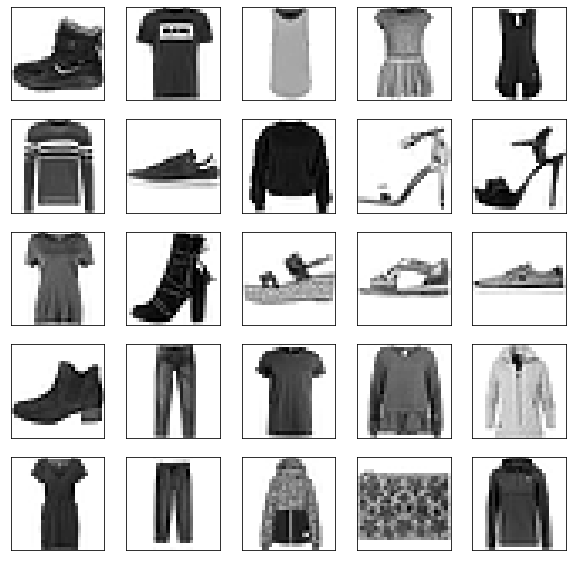

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

## Creating Batches of Training Data

In [5]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## Building the Generator Network for GAN

In [6]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh')
])


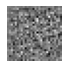

In [7]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)
plot_utils.show(generated_image, 1)

## Building the Discriminator Network for DCGAN

In [8]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50106907]], shape=(1, 1), dtype=float32)


## Compiling the Deep Convolutional Generative Adversarial Network (DCGAN)

In [10]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

## Training Procedure

In [11]:
seed = tf.random.normal(shape=[batch_size, 100])

In [12]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch + 1, epochs))
        for x_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch +1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [13]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Training DCGAN

In [14]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. -1.

In [15]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

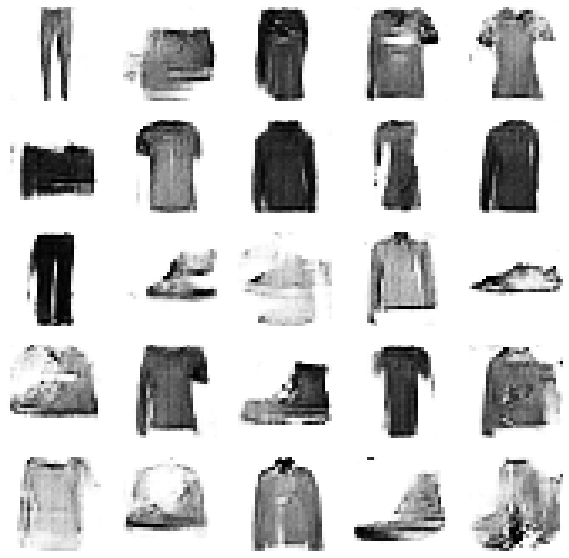

Wall time: 11min 26s


In [16]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 2)

## Generating Synthetic Images with DCGAN

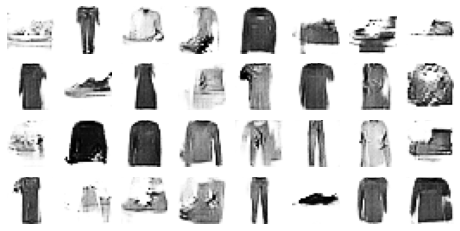

In [17]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images, 8)

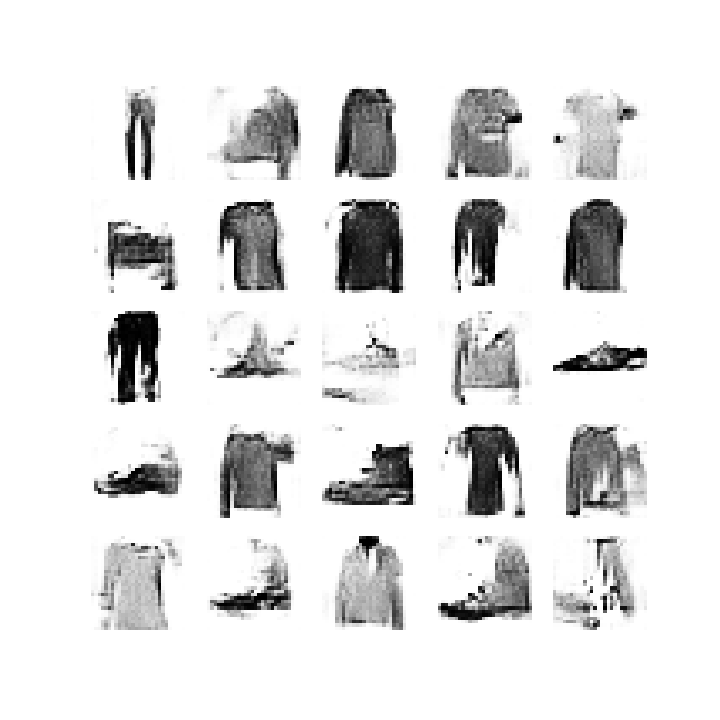

In [18]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)

In [19]:
decision = discriminator(generated_images)
print(decision)

tf.Tensor(
[[0.32496512]
 [0.24960032]
 [0.37606382]
 [0.37212875]
 [0.3166418 ]
 [0.08878085]
 [0.16080981]
 [0.30849218]
 [0.40275007]
 [0.38155824]
 [0.37892422]
 [0.17300338]
 [0.4007869 ]
 [0.5336496 ]
 [0.3207667 ]
 [0.3081013 ]
 [0.24812466]
 [0.13706958]
 [0.41288555]
 [0.15526363]
 [0.18045488]
 [0.20847699]
 [0.19890103]
 [0.26699746]
 [0.4340065 ]
 [0.13586524]
 [0.2271674 ]
 [0.17528722]
 [0.41091487]
 [0.43185827]
 [0.36425644]
 [0.49576938]], shape=(32, 1), dtype=float32)
